In [1]:
from __future__ import print_function, division, absolute_import
import os
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
import numpy as np
import time
from math import pi
import matplotlib.pyplot as plt
from orbithunter import *

Following the order of [Spatiotemporal Tiling of the Kuramoto-Sivashinsky Equation](#thesis), the next process that was developed after the ability to find periodic orbits was to clip out smaller domains and use them to find "fundamental periodic orbits". These are the smallest periodic orbits which serve as building blocks for all other solutions.


## Large spatiotemporal trajectory clipping.

Clipping is not limited to small orbits; the hypothesis is that orbits are shadowed throughout the entirety of space-time;
therefore we should be able to clip out patches of arbitrary trajectories and use them to find orbits. 

Next, import a trajectory populated via time integration.

In [2]:
integrated_trajectory = read_h5('../data/local/OrbitKS.h5', 'trajectory')
integrated_trajectory.plotting_dimensions()

((0.0, 512.0), (0.0, 57.62024423405479))

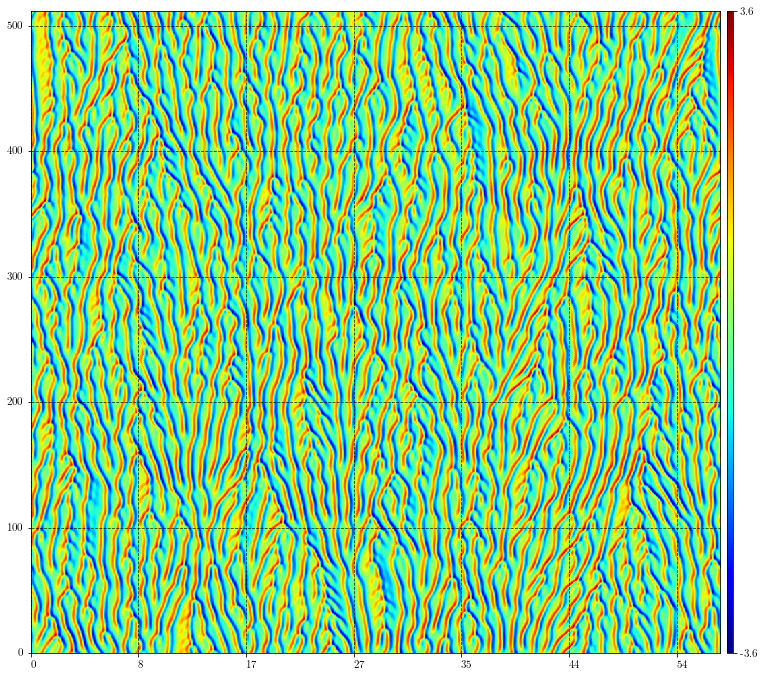

In [3]:
integrated_trajectory.plot()

Next, the region $t\in[200,280], x\in[27,29]$(multiples of $2\pi\sqrt{2}$) is cut out, the interior
and exterior of the clipping can be plotted using numpy array masking; accessible through the ```clipping_mask``` function;
```clipping_mask``` behaves in nearly the same way as ```clip``` except if desired, an iterable of windows can be passed,
in order to show/hide multiple regions of space-time.

The clipping automatically calculates the corresponding field, discretization, parameters. This is designed to work for $d+1$ dimensional spacetime with vector equations, but has yet to be tested for these cases. 

In [4]:
masked_field = clipping_mask(integrated_trajectory,  ((120, 160), (34.25, 38)), mask_region='exterior')
masked_field.plot()

TypeError: clipping_mask() got an unexpected keyword argument 'mask_region'

In [ ]:
masked_field = clipping_mask(integrated_trajectory,  ((120, 160), (34.25, 38)), mask_region='interior')
masked_field.plot()

Next, retrieve the actual guess orbit, not its masking, produced from clipping and initialize it as a relative periodic
orbit. The reshaping is simply for reproducibility if default discretization sizes change. 

In [ ]:
integrated_trajectory = read_h5('../data/local/OrbitKS.h5', 'trajectory')
clipping = clip(integrated_trajectory,  ((120, 160), (34.25, 38)),
                clipping_class=RelativeOrbitKS).resize(16,16).resize(32, 32)
clipping.populate(attr='parameters')
clipping.plot(fundamental_domain=True)

Note that even though the clipping tiles' spatial domain size was specified to be $2*(2*\pi\sqrt{2})$, the discrete
nature of the problem means that we must take the nearest discrete increment, hence, unless the window boundaries
are separated by a multiple of $L/M$, the clipping will not be returned with the $L$ defined by the boundaries;
also, $N,M$ are required to be even, this might also result in an unexpected size.

Let us pass the clipping to optimization, and see if it converges.

In [ ]:
clipping_result = hunt(clipping.transform(to='modes'), methods=('adj', 'lstsq'),
                       maxiter=(50000, 500), preconditioning=True, ftol=0, verbose=True)

In [ ]:
clipping_result.orbit.plot()

The resulting orbit is much longer in time, and approximately the same size in space; 

# Primary usage: fundamental orbits via clipping

The main reason clipping was developed was to extract fundamental orbits from larger orbits; the fundamental
orbits represent the building blocks of turbulence, as demonstrated in ```gluing_demo.ipynb```. To extract a fundamental
orbit, first identify a pattern defined on a minimal space-time tile; then clip it out and optimize it. It may or may
not take multiple steps, i.e. small clip->optimize-> another small clip, another optimize, etc.

In [ ]:
# small vanity rotations to make clipping easier
orbit_ = read_h5('../data//local/OrbitKS.h5', 't54p126_x26p744')#.rotate(0.1, axis=1).rotate(2, axis=0).reshape(512,512)
orbit_.plot()
orbit_.rotate(1, axis=1).plot()

The structure defined approximately on $t \in [0, 35], \forall x$ looks to repeat twice. Therefore this is the target of the first clipping. Again, **I want to stress that this iterative manner of clipping is unnecessary**, but it was how this calculation was originally performed. The clipping automatically calculates the corresponding field, discretization, parameters. This is designed to work for $d+1$ dimensional spacetime with vector equations, but of course would need testing.

In [ ]:
first_clipping = clip(orbit_.reshape(512,512), ((0., 35), (None, None))).reshape(16, 20).transform(to='modes')
first_orbit = converge(first_clipping,  method='lstsq', verbose=True, ftol=0).orbit
first_orbit.plot()

In [ ]:
second_clipping = clip(first_orbit.reshape(512,512), ((0., 20), (None, None))).reshape(16, 20).transform(to='modes')
second_orbit = converge(second_clipping, method='lstsq', verbose=True, ftol=0).orbit
second_orbit.plot()

In [ ]:
third_clipping = clip(second_orbit.reshape(512,512), ((None, None), (0, 2.1))).reshape(16, 20).transform(to='modes')
third_orbit = converge(third_clipping, method='lstsq', verbose=True, ftol=0).orbit
third_orbit.plot()

For this demonstration, I will use the very first orbit and clipping method I ever applied, which was an iterative procedure to find (converge) a sequence of progressively smaller orbits.

In [ ]:
antisymmetric_clipping = convert_class(third_orbit, AntisymmetricOrbitKS)
third_orbit = converge(antisymmetric_clipping, method='lstsq', verbose=True, ftol=0).orbit
_ = print('Residual =',third_orbit.cost())
_ = third_orbit.plot(fundamental_domain=True)


Going by the cost the clipping does indeed exist in the antisymmetric subspace!
By looking at the collection of orbits as well as time integrated trajectories the important patterns were identified
these are denoted as **fundamental periodic orbits**. 

Now, under the hypothesis that there exists a spatiotemporal symbolic alphabet we can use the previous
result to find the next fundamental orbit. Namely, the only remaining structure post-clipping is a single wavelength. Therefore, this seems to be a likely candidate for another fundamental orbit.

In [ ]:
second_orbit.plot()

In [ ]:
mask_orbit(second_orbit.reshape(512,512), ((None, None),(2, None))).plot()

In [ ]:
streak_clipping = clip(second_orbit.reshape(512,512), ((None, None),(2, None)), clipping_class=EquilibriumOrbitKS)

In [ ]:
streak_result = converge(streak_clipping.reshape().transform(to='modes'), method='lstsq')

In [ ]:
streak_result

In [ ]:
2*pi*np.sqrt(2)

In [ ]:
streak_result.orbit.plot()

In [ ]:
defect_original = read_h5('RelativeOrbitKS_T12p836_L28p614.h5', 
                          directory='../data/local/orbithunter_thesis/tiles_and_cutouts/').reshape(512, 512)
defect_clipping = clip(defect_original.change_reference_frame(to='physical')
                        , ((None, None),(0.4, 2.2)), frame='physical')
defect_clipping = defect_clipping.change_reference_frame(to='comoving')

defect_original.plot(fundamental_domain=False)
mask_orbit(defect_original, ((None, None),(0.4, 2.2)), mask_region='interior').plot(padding=False, fundamental_domain=False)
mask_orbit(defect_original, ((None, None),(0.4, 2.2)), mask_region='exterior').plot(filename='defect_interior.pdf', 
                                                                                    directory='../data/local/orbithunter_thesis/clipping/',
                                                                                    padding=False, fundamental_domain=False)
defect_clipping.plot(fundamental_domain=False)

In [ ]:
defect_original.plot(filename='defect_initial.pdf', directory='../data/local/thesis/clipping/')

In [ ]:
defect_result = converge(defect_clipping.reshape(16, 16).transform(to='modes'), 
                         method='lstsq', verbose=True)

In [ ]:
defect_result.orbit.plot()

In [ ]:
defect_result.orbit.plot(fundamental_domain=True)

Major changes
-------------
Only because there has been no serious adoption by anyone, 
I am restarting the semantic versioning because the code has changed so much that the previous versions are in fact
not useful nor relevant anymore

\begin{itemize}
\item shadowing.py
Contains cover, shadow, scan tools to calculate statistics of shadowing.
\end{itemize}

In [ ]:
defect_result.orbit

In [ ]:
defect_result.orbit.to_h5('defect_large_family_member.h5', 
                          directory='../data/local/thesis/families/')

In [ ]:
defect_result

In [ ]:
from orbithunter.gluing import tile_dictionary_ks
td = tile_dictionary_ks(comoving=True)

In [ ]:
td[0].plot(figsize=(2,2))
td[1].plot(figsize=(2,2), padding=False)
td[2].plot(figsize=(2,2))

They were small in number ~5-7, but after further investigation via numerical continuation, it was shown that some of these
fundamental orbits were in fact the same.

This was a realization that fundamental periodic orbits exist in continuous families. This isn't a breakthrough by any stretch but in hindsight it makes a good amount of sense. Namely, solutions were already known to exist in continuous families.
Therefore, if all orbits are comprised of fundamental periodic orbits, they have to exist on "rubberized tiles"